In [17]:
import pandas as pd
import numpy as np
import math
import pickle
from datetime import datetime

from scipy import stats
import scipy.io
from scipy.spatial.distance import pdist
from scipy.linalg import cholesky
from scipy.io import loadmat


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,roc_auc_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from src import SMOTE
from src import CFS
from src import metrices_V2 as metrices

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os
import copy
import traceback
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
def apply_smote(df):
    df.reset_index(drop=True,inplace=True)
    cols = df.columns
    smt = SMOTE.smote(df)
    df = smt.run()
    df.columns = cols
    return df

def apply_cfs(df):
        y = df.Bugs.values
        X = df.drop(labels = ['Bugs'],axis = 1)
        X = X.values
        selected_cols = CFS.cfs(X,y)
        cols = df.columns[[selected_cols]].tolist()
        cols.append('Bugs')
        return df[cols],cols

In [3]:
def load_data_commit_level(project,metric):
    understand_path = 'data/understand_files_all/' + project + '_understand.csv'
    understand_df = pd.read_csv(understand_path)
    understand_df = understand_df.dropna(axis = 1,how='all')
    cols_list = understand_df.columns.values.tolist()
    for item in ['Kind', 'Name','commit_hash', 'Bugs']:
        if item in cols_list:
            cols_list.remove(item)
            cols_list.insert(0,item)
    understand_df = understand_df[cols_list]
    cols = understand_df.columns.tolist()
    understand_df = understand_df.drop_duplicates(cols[4:len(cols)])
    understand_df['Name'] = understand_df.Name.str.rsplit('.',1).str[1]
    
    commit_guru_file_level_path = 'data/commit_guru_file/' + project + '.csv'
    commit_guru_file_level_df = pd.read_csv(commit_guru_file_level_path)
    commit_guru_file_level_df['commit_hash'] = commit_guru_file_level_df.commit_hash.str.strip('"')
    commit_guru_file_level_df = commit_guru_file_level_df[commit_guru_file_level_df['file_name'].str.contains('.java')]
    commit_guru_file_level_df['Name'] = commit_guru_file_level_df.file_name.str.rsplit('/',1).str[1].str.split('.').str[0].str.replace('/','.')
    commit_guru_file_level_df = commit_guru_file_level_df.drop('file_name',axis = 1)
    
    release_df = pd.read_pickle('data/release/' + project + '_release.pkl')
    release_df = release_df.sort_values('created_at',ascending=False)
    release_df = release_df.reset_index(drop=True)
    release_df['created_at'] = pd.to_datetime(release_df.created_at)
    release_df['created_at'] = release_df.created_at.dt.date
    
    commit_guru_path = 'data/commit_guru/' + project + '.csv' 
    commit_guru_df = pd.read_csv(commit_guru_path)
    cols = understand_df.columns.tolist()
    commit_guru_df['created_at'] = pd.to_datetime(commit_guru_df.author_date_unix_timestamp,unit='s')
    commit_guru_df['created_at'] = commit_guru_df.created_at.dt.date
    
    commit_guru_df = commit_guru_df[['commit_hash','created_at']]
    
    df = understand_df.merge(commit_guru_file_level_df,how='left',on=['commit_hash','Name'])
    df = df.merge(commit_guru_df,how='left',on=['commit_hash'])


    
    cols = df.columns.tolist()
    cols.remove('Bugs')
    cols.append('Bugs')
    df = df[cols]
    commit_hash = df.commit_hash
    for item in ['Kind', 'Name','commit_hash']:
        if item in cols:
            df = df.drop(labels = [item],axis=1)
    df = df.drop_duplicates()
    df.reset_index(drop=True, inplace=True)
    
    created_at = df.created_at
    df = df.drop('created_at',axis = 1)
    y = df.Bugs
    X = df.drop('Bugs',axis = 1)
    cols = X.columns
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X,columns = cols)
    imp_mean = IterativeImputer(random_state=0)
    X = imp_mean.fit_transform(X)
    X = pd.DataFrame(X,columns = cols)
    X['created_at'] = created_at
    
    if metric == 'process':
        X = X[['file_la', 'file_ld', 'file_lt', 'file_age', 'file_ddev',
       'file_nuc', 'own', 'minor', 'file_ndev', 'file_ncomm', 'file_adev',
       'file_nadev', 'file_avg_nddev', 'file_avg_nadev', 'file_avg_ncomm',
       'file_ns', 'file_exp', 'file_sexp', 'file_rexp', 'file_nd', 'file_sctr','created_at']]
    elif metric == 'product':
        X = X.drop(['file_la', 'file_ld', 'file_lt', 'file_age', 'file_ddev',
       'file_nuc', 'own', 'minor', 'file_ndev', 'file_ncomm', 'file_adev',
       'file_nadev', 'file_avg_nddev', 'file_avg_nadev', 'file_avg_ncomm',
       'file_ns', 'file_exp', 'file_sexp', 'file_rexp', 'file_nd', 'file_sctr'],axis = 1)
    else:
        X = X
    
    df = X
    df['Bugs'] = y
    df['commit_hash'] = commit_hash
    unique_commits = df.commit_hash.unique()
    
    count = 0
    last_train_date = None
    test_size = 0
    test_releases = []
    for release_date in release_df.created_at.unique()[:-1]:
        test_df =  df[(df.created_at >= release_date)]
#         print(test_df.shape)
        if (test_df.shape[0]) > 2 and (test_df.shape[0] > test_size):
            count += 1
            last_train_date = release_date
            test_size = test_df.shape[0]
            test_releases.append(release_date)
        if count == 4:
            print("breaking")
            break
            
#     print(count,test_releases)
    
    if count < 4:
        print('not enough releases')
        return df,df,0
    
    train_df =  df[df.created_at < last_train_date]
    test_df =  df[df.created_at >= last_train_date]
    test_df = test_df.reset_index(drop= True)
    test_df['release'] = [0]*test_df.shape[0]
    
    i = 0
    

    for release_date in test_releases:
        test_df.loc[test_df['created_at'] < release_date,'release'] = i
        i += 1
    
    train_df = train_df.drop('created_at',axis = 1)
    test_df = test_df.drop('created_at',axis = 1)
    
    if train_df.shape[0] == 0:
        return df,df,0
    
    if test_df.shape[0] == 0:
        return df,df,0
    
    
    return train_df,test_df,1



In [6]:
def run_self_release(project,metric):
    precision = []
    recall = []
    pf = []
    f1 = []
    g_score = []
    auc = []
    pci_20 = []
    ifa = []
    train_probability = []
    predicted_probability = []
    test_probability = []
    train_df,test_df,success = load_data_commit_level(project,metric)
    if success == 0:
        return 0,0,0,0,0,0,0,0,0,0,0,0
    train_df = train_df.drop('commit_hash',axis = 1)
    previous_X = pd.DataFrame()
    previous_y = []
    for release in test_df.release.unique():
        if len(previous_y) == 0:
            y = train_df.Bugs.values.tolist()
            X = train_df.drop('Bugs',axis = 1)
            df_smote = X
            df_smote['Bugs'] = y
            df_smote = apply_smote(df_smote)
            y_train = df_smote.Bugs
            X_train = df_smote.drop('Bugs',axis = 1)
            clf =  RandomForestClassifier()
            clf.fit(X_train,y_train)
            importance = clf.feature_importances_
        else:
            y = train_df.Bugs.values.tolist()
            X = train_df.drop('Bugs',axis = 1)
            y = y + previous_y
            X = pd.concat([X,previous_X], axis = 0)
            df_smote = X
            df_smote['Bugs'] = y
            df_smote = apply_smote(df_smote)
            y_train = df_smote.Bugs
            X_train = df_smote.drop('Bugs',axis = 1)
            clf =  RandomForestClassifier()
            clf.fit(X_train,y_train)
            importance = clf.feature_importances_
        test_df_subset = test_df[test_df['release'] == release]
        test_df_subset = test_df_subset.drop('release',axis = 1)
        
        y_test = test_df_subset.Bugs
        X_test = test_df_subset.drop(['Bugs','commit_hash'],axis = 1)
        
        previous_X = X_test
        previous_y = y_test.values.tolist()
        
        if metric == 'process':
            loc = X_test['file_la'] + X_test['file_lt']
        elif metric == 'product':
            loc = X_test.CountLineCode
        else:
            loc = X_test['file_la'] + X_test['file_lt']                 
        predicted = clf.predict(X_test)
        abcd = metrices.measures(y_test,predicted,loc)
        pf.append(abcd.get_pf())
        recall.append(abcd.calculate_recall())
        precision.append(abcd.calculate_precision())
        f1.append(abcd.calculate_f1_score())
        g_score.append(abcd.get_g_score())
        pci_20.append(abcd.get_pci_20())
        ifa.append(abcd.get_ifa())
        try:
            auc.append(roc_auc_score(y_test, predicted))
        except:
            auc.append(0)
        train_probability.append(y.count(1)/len(y))
        
        y_test = y_test.values.tolist()
        predicted = list(predicted)
        
        predicted_probability.append(predicted.count(1)/len(predicted))
        test_probability.append(y_test.count(1)/len(y_test))
        print(classification_report(y_test, predicted))
#         print(recall,precision,pf,f1,g_score,auc,pci_20)
    return recall,precision,pf,f1,g_score,auc,pci_20,ifa,importance,train_probability,predicted_probability,test_probability

In [7]:
proj_df = pd.read_csv('projects.csv')
projects = proj_df.repo_name.tolist()

In [10]:
types = ['process','product','process+product']
for _type in types:
    precision_list = {}
    recall_list = {}
    pf_list = {}
    f1_list = {}
    g_list = {}
    auc_list = {}
    pci_20_list = {}
    ifa_list = {}
    featue_importance = {}
    train_probabilities = {}
    predicted_probabilities = {}
    test_probabilities = {}
    for project in projects:
        try:
            if project == '.DS_Store':
                continue
            print("+++++++++++++++++   "  + project + "  +++++++++++++++++")
            recall,precision,pf,f1,g_score,auc,pci_20,ifa,importance,train_probability,predicted_probability,test_probability = run_self_release(project,_type)
            if recall == 0 and precision == 0 and pf == 0:
                continue
            recall_list[project] = recall
            precision_list[project] = precision
            pf_list[project] = pf
            f1_list[project] = f1
            g_list[project] = g_score
            auc_list[project] = auc
            pci_20_list[project] = pci_20
            ifa_list[project] = ifa
            featue_importance[project] = importance
            train_probabilities[project] = train_probability
            predicted_probabilities[project] = predicted_probability
            test_probabilities[project] = test_probability
        except Exception as e:
            print(e)
            continue
    final_result = {}
    final_result['precision'] = precision_list
    final_result['recall'] = recall_list
    final_result['pf'] = pf_list
    final_result['f1'] = f1_list
    final_result['g'] = g_list
    final_result['auc'] = auc_list
    final_result['pci_20'] = pci_20_list
    final_result['ifa'] = ifa_list
    final_result['featue_importance'] = featue_importance
    final_result['train_probability'] = train_probabilities
    final_result['predicted_probability'] = predicted_probabilities
    final_result['test_probability'] = test_probabilities

    with open('results/Final_results/RQ1_release_' + _type + '.pkl', 'wb') as handle:
            pickle.dump(final_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

+++++++++++++++++   600SeriesAndroidUploader  +++++++++++++++++
breaking
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       254
           1       0.81      1.00      0.89       252

    accuracy                           0.88       506
   macro avg       0.90      0.88      0.88       506
weighted avg       0.90      0.88      0.88       506

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        16

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

              precision    recall  f1-score   support

           0       1.00      0.74      0.85       293
           1       0.55      1.00      0.71        91

    accuracy                           0.80       384
   macro avg       0.77      0.87      0.78       384
w

breaking
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.67      0.80         3

    accuracy                           0.75         4
   macro avg       0.75      0.83      0.73         4
weighted avg       0.88      0.75      0.77         4

              precision    recall  f1-score   support

           0       0.82      1.00      0.90         9
           1       1.00      0.75      0.86         8

    accuracy                           0.88        17
   macro avg       0.91      0.88      0.88        17
weighted avg       0.90      0.88      0.88        17

+++++++++++++++++   Amadeus  +++++++++++++++++
breaking
        

not enough releases
+++++++++++++++++   aliyun-oss-android-sdk  +++++++++++++++++
breaking
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

              precision    recall  f1-score   support

           0       0.52      0.68      0.59        19
           1       0.62      0.45      0.53        22

    accuracy                           0.56        41
   macro avg       0.57      0.57      0.56        41
weighted avg       0.58      0.56      0.56        41

              precision    recall  f1-score   support

           0       1.00      0.52      0.69        23
           1       0.31      1.00      0.48         5

    accuracy                           0.61        28
   macro avg       0.66      0.76    

not enough releases
+++++++++++++++++   addressbook-level4  +++++++++++++++++
not enough releases
+++++++++++++++++   aem-core-wcm-components  +++++++++++++++++
breaking
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.95      0.97        20

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        44

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        45

    accuracy

breaking
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



# Compare Performance of process, product for release level prediction (RQ1)

In [12]:
dfs = ['process','product','process+product']
final_df = pd.DataFrame()
metrics = ['precision', 'recall', 'pf', 'auc', 'pci_20','ifa']
i = 0
for metric in metrics:
    data = []
    for df in dfs:
        file = pd.read_pickle('results/Final_results/RQ1_release_' + df + '.pkl')
        if metric == 'ifa':
            l = [np.nanmedian(sublist)/100 for sublist in list(file[metric].values())]
        else:
            l = [np.nanmedian(sublist) for sublist in list(file[metric].values())]
#         print(metric,df,np.nanmedian(l))
        data.append(l)
    data_df = pd.DataFrame(data)
    data_df.index = [['P','C','P+C']]
    x = pd.melt(data_df.T)
    x.columns = ['Metric Type','Score']
    if metric == 'pci_20':
        metric = 'popt_20'
    x['Evaluation Criteria'] = [metric]*x.shape[0]
    final_df = pd.concat([final_df,x])
final_df.columns = x.columns

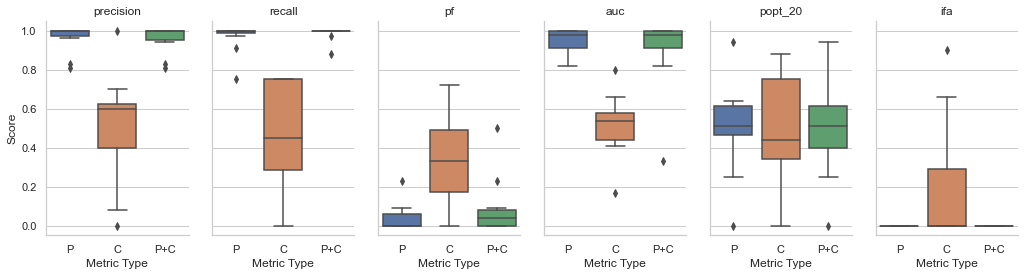

In [13]:
sns.set(style='whitegrid',font_scale=1)
order = ["P", "C", "P+C"]
g = sns.catplot(x="Metric Type", y="Score", col="Evaluation Criteria",height=4,aspect=0.6,margin_titles=True,kind="box", 
                order=order, data=final_df)
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
# g.savefig('results/image/RF_release_dev_set3.pdf')

# compare stability across releases (RQ4)

In [26]:
count = 0
dfs = ['process','product','process+product']
orders = ["P", "C", "P+C"]
metrics = ['precision', 'recall', 'pf', 'auc', 'pci_20','ifa']
all_results = pd.DataFrame()
for k in range(len(dfs)):
    df = dfs[k]
    order = orders[k]
    result_df = pd.DataFrame()
    final_result = pd.read_pickle('results/Final_results/RQ1_release_' + df + '.pkl')
    for metric in metrics:
        final_df = pd.DataFrame()
        release = [[],[],[]]
        for projects in final_result[metric].keys():
            if len(final_result[metric][projects]) < 3:
                continue
            count += 1
            i = 0
            for value in final_result[metric][projects]:
                if metric == 'ifa':
                    value = value/100
                release[i].append(value)
                i += 1
                if i == 3:
                    break
        for j in range(3):
            score_df = pd.DataFrame(release[j], columns = ['scores'])
            score_df['release'] = [j+1]*score_df.shape[0]
            final_df = pd.concat([final_df,score_df], axis = 0)
        final_df['metrics'] = [metric]*final_df.shape[0]
        result_df = pd.concat([result_df,final_df], axis = 0)
    result_df['Metric Type'] = [order]*result_df.shape[0]
    all_results = pd.concat([all_results,result_df])
all_results = all_results[all_results['metrics'] != 'featue_importance']

all_results = all_results[all_results['Metric Type'] != 'P+C']
all_results = all_results[all_results['metrics'] != 'g']
all_results = all_results[all_results['metrics'] != 'f1']

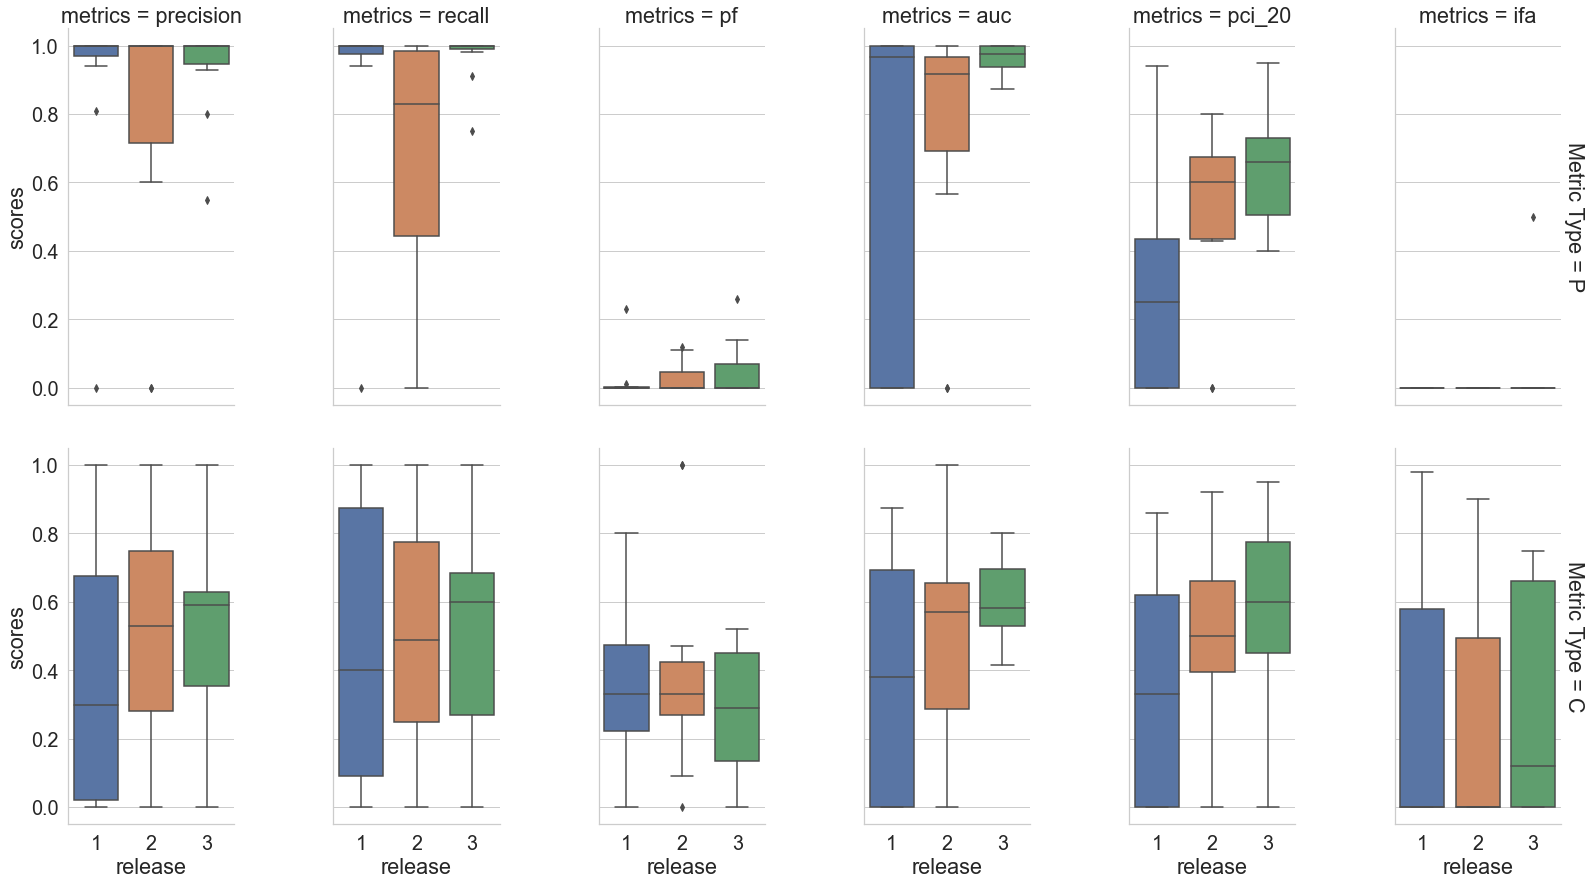

In [27]:
g = sns.set(style='whitegrid',font_scale=1.8)
order = [1,2,3]
g = sns.catplot(x="release", y="scores", col="metrics",row="Metric Type" ,height=4,aspect=0.6,margin_titles=True,kind="box", 
                order=order, data=all_results)
g.fig.set_figwidth(24)
g.fig.set_figheight(14)
g.savefig('results/image/RF_release_dev_set3.pdf')